# PZT Induced NDT of PE Pipes

# Domain Transformation

This python script reads the input data structures from the Signal Data Processing and Visualization script. It transforms the signals from the time domain to other domains (frequency, DWT, CWT).  

## User Inputs

All of the data is stored in an excel file in which waveguide material properties, crack geometry, FEM mesh, transducer specifications, and other such parameters are identified for each signal. The signals in this file have a sampling frequency of 100 MSa/s and duration of 5 $\mu$s. Specify this excel file under filename.

In [343]:
# Stored Data
filename = 'G:/My Drive/USGW Research/Programming/Git Cloud/USGW-in-PE-Pipes/Sensed Signals.xlsx'

# Parameters
Pipe     = 'Abaqus Model'

# Material Properties
Elasticity  = 'Elastic'
Modulus     = 1.1      # GPa
Poissons    = 0.45     # microstrains/microstrains
Density     = 1125      # kg/m^3

# Crack Geometry
Orientation   = 90;       # degrees
Location      = 100;     # mm
Depth         = 5;      # mm
Length        = 2*Depth; # mm
Width         = 2;       # mm
Circumference = 'Outside'
Order         = 1;

# Signal
Amplitude   = 0.1;       # N
Frequency   = 50000;     # Hz
Sampling    = 10000000;  # Sa/s
Cycles      = 5;

# Mesh
meshmax     = 1;            # mm
# meshmin     = 0.5;          # mm
timestep    = 1/Sampling;   # s

# Transducers
StrainCoefficient = 'U3'
PZTType           = 'Point'
Arrays            = ['R'];
Axes              = [3,4,5,6,7];

# All variables are frozen except one
variables = ['Length (mm)','Depth (mm)','Circumference']

# Artificially generated white noise
SNR = 70;

# Storage of Analysis Results
parent    = 'G:/My Drive/USGW Research/Programming/Git Cloud/USGW-in-PE-Pipes'
directory = 'Length Damaged States Perpendicular Crack'

## Preprocessing Code

### Importing Modules

In [344]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
from PIL import Image
import scipy as sp
from scipy.fft import fft, ifft
from scipy import signal
import scipy.fftpack
import math
import pywt

Obtain the frequency domains of all the signals in the dataframe in the form of the Single-Sided Amplitude Spectrum:

In [345]:
def ssas (Fs, time_domain):
    (L,n)    = np.shape(time_domain);               # Size of the time domain database (number of signasl x number of samples)
    T        = 1/Fs;                                # Sampling period
    duration = time_domain.columns[-1] - time_domain.columns[0]
    t        = np.arange(0,duration + T, T);        # Zeroed time axis in seconds
    
    # Power Spectrum
    Y = [];                                         # Power Spectrum
    i = 0;
    for index, row in time_domain.iterrows():
        Y.append(fft(row.values));
        i = i + 1;
        
    # Normalized magnitude of the power spectrum
    P2 = [];
    P1 = [];
    i = 0;
    
    while i < L:
        p2                   = abs(Y[i]);               # Double-sided Amplitude Spectrum
        p1                   = p2[0:math.ceil(n/2)];
        p1[1:math.ceil(n/2)] = 2*p1[1:math.ceil(n/2)];  # Single-sided Amplitude Spectrum
        i = i + 1;
        
        P2.append(p2)
        P1.append(p1)
        
    # Frequency domain dataframe
    f  = Fs*list(range(0,math.ceil(n/2)))/n;            # Frequency Axis
    P1 = pd.DataFrame(P1);
    freq_dom_title = [];
    for freq in f:
        freq_dom_title.append('Frequency Domain (Hz)')
    
    header     = [freq_dom_title, f];
    P1         = pd.DataFrame(P1);
    P1.columns = header;
    
    return P1;

### Point to Directory

In [346]:
cwd = os.getcwd
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Cloud\USGW-in-PE-Pipes\Length Damaged States Perpendicular Crack


In [347]:
os.chdir(parent)
print(os.getcwd())

G:\My Drive\USGW Research\Programming\Git Cloud\USGW-in-PE-Pipes


In [348]:
try: 
    os.mkdir(directory) 
except OSError as error: 
    print(error) 
    
path = os.path.join(directory)
os.chdir(path)

[WinError 183] Cannot create a file when that file already exists: 'Length Damaged States Perpendicular Crack'


### Load Data Structures

In [349]:
mode             = pickle.load(open('Mode 1, ' + StrainCoefficient + ' Signal Response','rb'))
averaged_signals = pickle.load(open('Mode 1 Averaged, ' + StrainCoefficient + ' Signal Response','rb'))
max_signals      = pickle.load(open('Mode 1 Max, ' + StrainCoefficient + ' Signal Response','rb'))
min_signals      = pickle.load(open('Mode 1 Min, ' + StrainCoefficient + ' Signal Response','rb'))
colors           = pickle.load(open('Color Code','rb'))
states           = pickle.load(open('Damaged States','rb'))
time             = pickle.load(open('Time Axis','rb'))

## Frequency Domain

The first domain transformation we will commence with is the frequency domain. This transformation will be performed through implementation of an FFT. Initially, this transformation will provide us with the power of each signal represented on the frequency domain. Upon solving for the single-sided amplitude spectrum, we will arrive at the amplitude of the signal represented on the frequency domain.

### Processing

In [350]:
duration = (time.transpose()[-1] - time.transpose()[0]);        # total duration of signal (s)
n = len(time.transpose());                                      # total number of samples in signal (Sa)
Fs = np.array((n-1)/duration);                                  # sampling frequency of signal (Sa/s)
T  = 1/Fs;                                                      # sampling period (s)

(L,n) = np.shape(mode['Time Domain (s)'])                       # size of the time domain database (number of signals x number of samples)
n     = np.array(n)                                             # Python is finicky with range
t     = np.arange(0,duration+T,T)                               # zeroed time axis in seconds

In [351]:
P1 = ssas(Fs, mode['Time Domain (s)'])
P1

Frequency Domain (Hz)                                            \
             0.000000e+00  9.999900e+03  1.999980e+04  2.999970e+04   
0            1.286060e-10  4.009064e-10  4.871349e-10  1.814725e-09   
1            1.533877e-10  4.564116e-10  5.538424e-10  1.962603e-09   
2            1.138378e-10  3.751073e-10  4.603188e-10  1.791542e-09   
3            1.533911e-10  4.564102e-10  5.538419e-10  1.962599e-09   
4            1.286106e-10  4.009102e-10  4.871401e-10  1.814728e-09   
..                    ...           ...           ...           ...   
520          2.752992e-11  1.181190e-10  2.960240e-10  1.113167e-09   
521          2.353292e-11  9.123024e-11  2.916725e-10  1.102938e-09   
522          2.195957e-11  1.120965e-10  2.828964e-10  1.098609e-09   
523          2.272079e-11  1.419584e-10  2.944409e-10  1.111779e-09   
524          2.343780e-11  1.454684e-10  2.757332e-10  1.107045e-09   

                                                                           \
     3.999960e+04  4.999950e+04  5.999940e+04  6.999930e+04  7.999920e+04   
0    1.355321e-08  4.440695e-09  3.608443e-09  1.912659e-09  1.308571e-09   
1    1.380080e-08  4.460346e-09  3.715298e-09  1.901238e-09  1.309177e-09   
2    1.348470e-08  4.317187e-09  3.793866e-09  1.870829e-09  1.282623e-09   
3    1.380079e-08  4.460346e-09  3.715296e-09  1.901236e-09  1.309177e-09   
4    1.355321e-08  4.440695e-09  3.608443e-09  1.912657e-09  1.308570e-09   
..            ...           ...           ...           ...           ...   
520  1.160872e-08  4.024933e-09  4.141009e-09  1.861646e-09  1.260335e-09   
521  1.160120e-08  4.021921e-09  4.148330e-09  1.868717e-09  1.251064e-09   
522  1.159660e-08  4.056443e-09  4.133061e-09  1.867206e-09  1.245089e-09   
523  1.160379e-08  4.069989e-09  4.137800e-09  1.888749e-09  1.281265e-09   
524  1.159900e-08  4.062232e-09  4.144675e-09  1.886238e-09  1.290619e-09   

                   ...                                            \
     8.999910e+04  ...  4.899951e+06  4.909951e+06  4.919951e+06   
0    1.040546e-09  ...  1.808010e-11  1.807915e-11  1.807808e-11   
1    1.018684e-09  ...  1.800399e-11  1.800341e-11  1.800070e-11   
2    9.852066e-10  ...  1.737309e-11  1.737201e-11  1.737072e-11   
3    1.018684e-09  ...  1.800358e-11  1.800325e-11  1.800119e-11   
4    1.040546e-09  ...  1.808051e-11  1.807838e-11  1.807844e-11   
..            ...  ...           ...           ...           ...   
520  1.038689e-09  ...  6.156755e-11  2.551583e-11  9.951940e-12   
521  1.024770e-09  ...  9.598885e-11  3.343791e-11  1.110272e-11   
522  1.017647e-09  ...  7.998075e-11  5.076792e-11  3.766230e-11   
523  1.010604e-09  ...  9.313588e-11  2.411870e-11  2.595451e-11   
524  1.021033e-09  ...  1.109116e-10  3.583519e-11  3.800390e-11   

                                                                           \
     4.929951e+06  4.939951e+06  4.949950e+06  4.959950e+06  4.969950e+06   
0    1.807587e-11  1.807493e-11  1.807306e-11  1.807348e-11  1.807331e-11   
1    1.799986e-11  1.800076e-11  1.799631e-11  1.799689e-11  1.799613e-11   
2    1.736912e-11  1.736837e-11  1.736696e-11  1.736592e-11  1.736506e-11   
3    1.799892e-11  1.800037e-11  1.799578e-11  1.799682e-11  1.799669e-11   
4    1.807700e-11  1.807601e-11  1.807319e-11  1.807324e-11  1.807354e-11   
..            ...           ...           ...           ...           ...   
520  8.555643e-11  6.719943e-11  5.391390e-11  7.483189e-11  4.508725e-11   
521  7.935418e-11  6.381430e-11  3.012043e-11  7.823993e-11  2.762749e-11   
522  8.751729e-11  7.982502e-11  3.799832e-11  7.054723e-11  1.726995e-11   
523  8.785908e-11  7.014813e-11  4.580504e-11  6.579890e-11  2.169237e-11   
524  9.754045e-11  7.808160e-11  4.726805e-11  4.883630e-11  2.848604e-11   

                                 
     4.979950e+06  4.989950e+06  
0    1.807216e-11  1.807200e-11  
1    1.799636e-11  1.799517e-11  
2    1.736550e-11  1.736434e-11  
3    1.799752e-11  1.

Include the frequency domain in the mode-defining database and the averaged signals database

In [352]:
for freq in P1.columns:
    mode[freq] = P1[freq].values

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_24048/1933889382.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  mode[freq] = P1[freq].values


In [353]:
P1_averaged = ssas(Fs, averaged_signals['Time Domain (s)'])
for freq in P1_averaged.columns:
    averaged_signals[freq] = P1_averaged[freq].values

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_24048/555576235.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  averaged_signals[freq] = P1_averaged[freq].values


In [383]:
P1_max = ssas(Fs, max_signals['Time Domain (s)'])
for freq in P1_max.columns:
    max_signals[freq] = P1_max[freq].values

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_24048/90348678.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  max_signals[freq] = P1_max[freq].values


In [384]:
P1_min = ssas(Fs, min_signals['Time Domain (s)'])
for freq in P1_min.columns:
    min_signals[freq] = P1_min[freq].values

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_24048/1466495777.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  min_signals[freq] = P1_min[freq].values


In [354]:
mode['Frequency Domain (Hz)']

0.000000e+00  9.999900e+03  1.999980e+04  2.999970e+04  3.999960e+04  \
130  1.286060e-10  4.009064e-10  4.871349e-10  1.814725e-09  1.355321e-08   
131  1.533877e-10  4.564116e-10  5.538424e-10  1.962603e-09  1.380080e-08   
132  1.138378e-10  3.751073e-10  4.603188e-10  1.791542e-09  1.348470e-08   
133  1.533911e-10  4.564102e-10  5.538419e-10  1.962599e-09  1.380079e-08   
134  1.286106e-10  4.009102e-10  4.871401e-10  1.814728e-09  1.355321e-08   
..            ...           ...           ...           ...           ...   
163  2.752992e-11  1.181190e-10  2.960240e-10  1.113167e-09  1.160872e-08   
163  2.353292e-11  9.123024e-11  2.916725e-10  1.102938e-09  1.160120e-08   
163  2.195957e-11  1.120965e-10  2.828964e-10  1.098609e-09  1.159660e-08   
163  2.272079e-11  1.419584e-10  2.944409e-10  1.111779e-09  1.160379e-08   
163  2.343780e-11  1.454684e-10  2.757332e-10  1.107045e-09  1.159900e-08   

     4.999950e+04  5.999940e+04  6.999930e+04  7.999920e+04  8.999910e+04  \
130  4.440695e-09  3.608443e-09  1.912659e-09  1.308571e-09  1.040546e-09   
131  4.460346e-09  3.715298e-09  1.901238e-09  1.309177e-09  1.018684e-09   
132  4.317187e-09  3.793866e-09  1.870829e-09  1.282623e-09  9.852066e-10   
133  4.460346e-09  3.715296e-09  1.901236e-09  1.309177e-09  1.018684e-09   
134  4.440695e-09  3.608443e-09  1.912657e-09  1.308570e-09  1.040546e-09   
..            ...           ...           ...           ...           ...   
163  4.024933e-09  4.141009e-09  1.861646e-09  1.260335e-09  1.038689e-09   
163  4.021921e-09  4.148330e-09  1.868717e-09  1.251064e-09  1.024770e-09   
163  4.056443e-09  4.133061e-09  1.867206e-09  1.245089e-09  1.017647e-09   
163  4.069989e-09  4.137800e-09  1.888749e-09  1.281265e-09  1.010604e-09   
163  4.062232e-09  4.144675e-09  1.886238e-09  1.290619e-09  1.021033e-09   

     ...  4.899951e+06  4.909951e+06  4.919951e+06  4.929951e+06  \
130  ...  1.808010e-11  1.807915e-11  1.807808e-11  1.807587e-11   
131  ...  1.800399e-11  1.800341e-11  1.800070e-11  1.799986e-11   
132  ...  1.737309e-11  1.737201e-11  1.737072e-11  1.736912e-11   
133  ...  1.800358e-11  1.800325e-11  1.800119e-11  1.799892e-11   
134  ...  1.808051e-11  1.807838e-11  1.807844e-11  1.807700e-11   
..   ...           ...           ...           ...           ...   
163  ...  6.156755e-11  2.551583e-11  9.951940e-12  8.555643e-11   
163  ...  9.598885e-11  3.343791e-11  1.110272e-11  7.935418e-11   
163  ...  7.998075e-11  5.076792e-11  3.766230e-11  8.751729e-11   
163  ...  9.313588e-11  2.411870e-11  2.595451e-11  8.785908e-11   
163  ...  1.109116e-10  3.583519e-11  3.800390e-11  9.754045e-11   

     4.939951e+06  4.949950e+06  4.959950e+06  4.969950e+06  4.979950e+06  \
130  1.807493e-11  1.807306e-11  1.807348e-11  1.807331e-11  1.807216e-11   
131  1.800076e-11  1.799631e-11  1.799689e-11  1.799613e-11  1.799636e-11   
132  1.736837e-11  1.736696e-11  1.736592e-11  1.736506e-11  1.736550e-11   
133  1.800037e-11  1.799578e-11  1.799682e-11  1.799669e-11  1.799752e-11   
134  1.807601e-11  1.807319e-11  1.807324e-11  1.807354e-11  1.807323e-11   
..            ...           ...           ...           ...           ...   
163  6.719943e-11  5.391390e-11  7.483189e-11  4.508725e-11  1.014734e-11   
163  6.381430e-11  3.012043e-11  7.823993e-11  2.762749e-11  1.267572e-11   
163  7.982502e-11  3.799832e-11  7.054723e-11  1.726995e-11  1.477745e-11   
163  7.014813e-11  4.580504e-11  6.579890e-11  2.169237e-11  2.128082e-11   
163  7.808160e-11  4.726805e-11  4.883630e-11  2.848604e-11  5.880365e-12   

     4.989950e+06  
130  1.807200e-11  
131  1.799517e-11  
132  1.736434e-11  
133  1.799557e-11  
134  1.807243e-11  
..            ...  
163  2.300719e-11  
163  1.870462e-11  
163  5.440828e-12  
163  1.088552e-11  
163  2.230298e-11  

[525 rows x 500 columns]

### Plots

Frequency Domain of the entire signal at once doesn't help us very much. It doesn't focus into the parts of the signal that describe the damage the best or provide particularly important information. This is why we're examining a single mode. Frequency characteristics of said mode should be very telling of the nature of the signal.

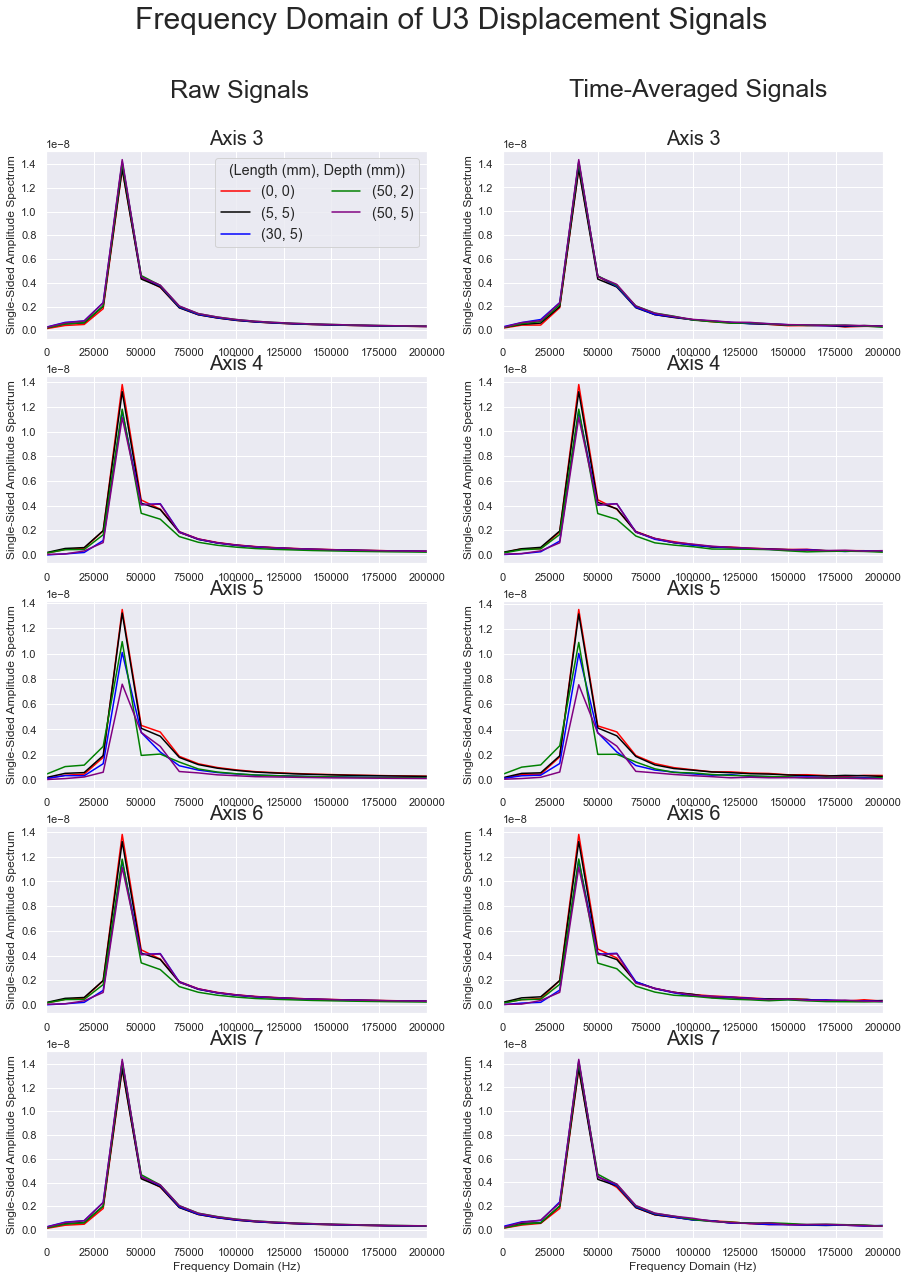

In [355]:
fig, ax = plt.subplots(len(Axes), 2, figsize = (15,20))
i = 0
textyloc = 0;

for axis in Axes:
    j = 0;
    subtitle = '';

    for state in states:

        is_state = (mode['Crack Properties',variables[0]] == state[0])&(mode['Crack Properties',variables[1]] == state[1]);
        is_axis  = mode['Transducer','Axis'] == axis;
        signal   = mode[is_state & is_axis];
        
        signal_freq = signal['Frequency Domain (Hz)']
        
        if np.nan in signal_freq:
            continue
            
        max_value = signal_freq.to_numpy().max()
        
        this_state = variables[0] + ' = ' + str(state[0]) + ', ' + variables[1] + ' = ' + str(state[1])
        ax[i][0].plot(f,signal_freq.to_numpy()[0], color = colors[j], label = this_state)
        ax[i][0].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)
        ax[i][0].grid(visible = True, which = 'major')        
        ax[i][0].set_xlim([0, 2e5])

        j = j + 1;
    
    i = i + 1
    
    ax[-1][0].set_xlabel('Frequency (Hz)', fontsize = 20)
    ax[-1][1].set_xlabel('Frequency (Hz)', fontsize = 20)
    
    textyloc = max(max_value*1.7,textyloc)
        
i = 0

for axis in Axes:
    j = 0;
    subtitle = '';

    for state in states:

        is_state = (averaged_signals['Crack Properties',variables[0]] == state[0])&(averaged_signals['Crack Properties',variables[1]] == state[1]);
        is_axis  = averaged_signals['Transducer','Axis'] == axis;
        signal   = averaged_signals[is_state & is_axis];
        
        signal_freq = signal['Frequency Domain (Hz)']
        
        if np.nan in signal_freq:
            continue
            
        max_value = signal_freq.to_numpy().max()
        
        this_state = variables[0] + ' = ' + str(state[0]) + ', ' + variables[1] + ' = ' + str(state[1])
        ax[i][1].plot(f,signal_freq.to_numpy()[0], color = colors[j], label = this_state)
        ax[i][1].set_ylabel('Single-Sided Amplitude Spectrum', fontsize = 12)
        ax[i][1].grid(visible = True, which = 'major')
        ax[i][1].set_xlim([0, 2e5])

        j = j + 1;
        
        subtitle = 'Axis ' + str(axis)
        ax[i][0].set_title(subtitle, fontsize = 20)
        ax[i][1].set_title(subtitle, fontsize = 20)
    
    i = i + 1
    
    ax[-1][0].set_xlabel('Frequency Domain (Hz)', fontsize = 12)
    ax[-1][1].set_xlabel('Frequency Domain (Hz)', fontsize = 12)
    
    textyloc = max(max_value*1.7,textyloc)
    
ax[0][0].text(65000, 0.8*textyloc, 'Raw Signals', fontsize = 25)
ax[0][1].text(35000, 0.8*textyloc, 'Time-Averaged Signals', fontsize = 25)

ax[0][0].legend(states, title = '(' + variables[0] + ', ' + variables[1] + ')', loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large', ncol = 2);

fig.suptitle('Frequency Domain of ' + StrainCoefficient + ' Displacement Signals', fontsize = 30)

fig.savefig('Frequency Domain',dpi = 250)

## Discrete Wavelet Transform (DWT)

Oftentimes an FFT operation cannot provide all the necessary information about the frequency behavior of a signal. Short spurts of high frequency which occur periodically may be present in a signal, but such spurts are captured poorly in an FFT. A discrete wavelet transform (DWT) or continuous wavelet transform (CWT) rectifies this through an operation that reconstructs the signal using a mother wavelet function that has been scaled and shifted throughout the time domain.

The discrete wavelet transform is an operation by which a mother wavelet (Daubacheis 1 in this case) is dilated and shifted across the domain of the signal in order to reconstruct it in a number of different sampling rates, and thus, frequency bands.

This operation shows a good deal of potential in nonstationary signals analysis due to excellent local zooming property of the wavelet. By shifting and dilating the mother wavelet, a particular set of function, the signal can be decomposed, which could preserve the temporal information.

DWT is a recursive operation which begins by analyzing a given signal by decomposing it into low and high frequency components. The low frequency detail response is saved, and the high frequency approximation is further decomposed. The procedure follows a Mallat tree decomposition, and continues for a user-specified number of cycles. 

In this study, each wavelet coefficient is examined as a feature. Damage effects may have greater influence on the shape of the wavelet details than on the time or frequency responses. 

[36] Zhang, Zi, et al. "Machine learning-enriched lamb wave approaches for automated damage detection." Sensors 20.6 (2020): 1790, https://doi.org/10.3390/s20061790

### Processing

Objective: Determine all of the domains in the 5th level wavelet decomposition of the signals in the mode dataframe. Store all these signals in the dataframe.

In [356]:
mode_dwts = {}
coeffs    = pywt.wavedec(mode['Time Domain (s)'], 'db1', mode = 'sym', level = 5);

i = 0;

while i < len(coeffs):
    coeff = coeffs[i]
    samples  = np.array(range(0,len(coeff[0])))
    timestep = duration/len(coeff[0])
    coeff_time = samples*timestep
    
    Coeff = pd.DataFrame(coeff);
    dwt_dom_title = [];
    
    for sample in coeff_time:
        if i == 0:
            decomp = 'Wavelet Approximation at Detail ' + str(len(coeffs)-1) + ' (s)'
        else:
            decomp = 'Wavelet at Detail ' + str(len(coeffs)-i) + ' (s)'
        dwt_dom_title.append(decomp);
    header = [dwt_dom_title, coeff_time];
    Coeff  = pd.DataFrame(coeff);
    Coeff.columns = header;
    
    mode_dwts[decomp] = Coeff;
    
    i = i + 1;

In [357]:
mode_dwts['Wavelet at Detail 1 (s)']

Wavelet at Detail 1 (s)                                            \
               0.000000e+00  1.998020e-07  3.996040e-07  5.994060e-07   
0              2.154554e-14  1.890804e-14  1.623517e-14  1.354109e-14   
1              1.907774e-14  1.651801e-14  1.393707e-14  1.133492e-14   
2              1.685743e-14  1.413506e-14  1.139856e-14  8.662058e-15   
3              1.907774e-14  1.651801e-14  1.393707e-14  1.134199e-14   
4              2.154554e-14  1.891511e-14  1.624224e-14  1.353402e-14   
..                      ...           ...           ...           ...   
520           -2.302571e-12  2.026809e-13  8.689308e-13  1.655653e-12   
521           -2.578738e-12  2.789898e-13  5.759815e-13  1.735154e-12   
522           -2.680304e-12  1.771630e-13  7.321109e-13  1.805254e-12   
523           -2.318681e-12  2.797129e-13  1.007971e-12  2.163271e-12   
524           -2.693213e-12 -1.155840e-13  1.050706e-12  2.176843e-12   

                                                                           \
     7.992080e-07  9.990100e-07  1.198812e-06  1.398614e-06  1.598416e-06   
0    1.079752e-14  8.032733e-15  5.253803e-15  2.439518e-15 -3.959798e-16   
1    8.725698e-15  6.088189e-15  3.450681e-15  7.990307e-16 -1.873833e-15   
2    5.918484e-15  3.181981e-15  4.525483e-16 -2.269813e-15 -4.985103e-15   
3    8.725698e-15  6.088189e-15  3.450681e-15  7.919596e-16 -1.866762e-15   
4    1.079752e-14  8.032733e-15  5.246732e-15  2.439518e-15 -3.889087e-16   
..            ...           ...           ...           ...           ...   
520  2.001314e-13  1.882074e-13 -4.450501e-13  9.878714e-13 -4.547173e-13   
521  6.130603e-13 -2.568008e-14 -5.737228e-13  1.384082e-12 -1.108166e-12   
522  4.052019e-13 -5.435948e-14 -1.030926e-12  1.144306e-12 -1.321163e-12   
523  1.773264e-13  1.100991e-13 -8.902599e-13  1.094715e-12 -1.376620e-12   
524  3.526251e-13  3.056963e-13 -8.589390e-13  1.167327e-12 -1.117441e-12   

                   ...                                            \
     1.798218e-06  ...  9.790298e-05  9.810278e-05  9.830258e-05   
0   -3.245620e-15  ...  2.952878e-13  2.684177e-13  2.402749e-13   
1   -4.546697e-15  ...  2.989647e-13  2.725190e-13  2.448711e-13   
2   -7.686251e-15  ...  2.711755e-13  2.444468e-13  2.165868e-13   
3   -4.553768e-15  ...  2.989647e-13  2.725190e-13  2.448711e-13   
4   -3.238549e-15  ...  2.952878e-13  2.683470e-13  2.403456e-13   
..            ...  ...           ...           ...           ...   
520  7.632279e-13  ... -2.695491e-12 -6.310850e-13 -7.318331e-13   
521  8.583921e-13  ... -2.887041e-12 -1.131487e-12 -8.436597e-13   
522  7.939019e-13  ... -3.234814e-12 -1.057941e-12 -8.984288e-13   
523  1.004424e-12  ... -2.935694e-12 -1.099365e-12 -4.634055e-13   
524  8.708592e-13  ... -2.807043e-12 -1.051943e-12 -7.265021e-13   

                                                                           \
     9.850239e-05  9.870219e-05  9.890199e-05  9.910179e-05  9.930159e-05   
0    2.111421e-13  1.810193e-13  1.500481e-13  1.184404e-13  8.619632e-14   
1    2.161625e-13  1.866055e-13  1.561292e-13  1.249458e-13  9.326738e-14   
2    1.878076e-13  1.581798e-13  1.278449e-13  9.694434e-14  6.554880e-14   
3    2.162333e-13  1.865348e-13  1.561292e-13  1.249458e-13  9.326738e-14   
4    2.112128e-13  1.810900e-13  1.501188e-13  1.184404e-13  8.612561e-14   
..            ...           ...           ...           ...           ...   
520  1.304632e-12  8.424983e-13  1.240393e-12 -7.529662e-13  2.971428e-13   
521  1.549010e-12  8.938550e-13  1.127993e-12 -4.476556e-13  2.009696e-13   
522  1.543456e-12  5.094394e-13  1.044217e-12 -7.504568e-13  7.379749e-13   
523  1.495270e-12  5.041905e-13  1.010155e-12 -7.970492e-13  5.463676e-13   
524  1.730337e-12  1.857038e-13  1.373356e-12 -7.470002e-13  6.007112e-13   

                                 
     9.950140e-05  9.970120e-05  
0    5.352798e-14  2.043539e-14  
1    6.102332e-14  2.856711e-14  
2    3.379970e-14  1.838478e-

In [358]:
for key in mode_dwts.keys():
    for timestep in mode_dwts[key].columns:
        mode[timestep] = mode_dwts[key][timestep].values

C:\Users\WEISUN~1\AppData\Local\Temp/ipykernel_24048/3637293332.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  mode[timestep] = mode_dwts[key][timestep].values


In [359]:
mode[key]

0.000000e+00  1.998020e-07  3.996040e-07  5.994060e-07  7.992080e-07  \
130  2.154554e-14  1.890804e-14  1.623517e-14  1.354109e-14  1.079752e-14   
131  1.907774e-14  1.651801e-14  1.393707e-14  1.133492e-14  8.725698e-15   
132  1.685743e-14  1.413506e-14  1.139856e-14  8.662058e-15  5.918484e-15   
133  1.907774e-14  1.651801e-14  1.393707e-14  1.134199e-14  8.725698e-15   
134  2.154554e-14  1.891511e-14  1.624224e-14  1.353402e-14  1.079752e-14   
..            ...           ...           ...           ...           ...   
163 -2.302571e-12  2.026809e-13  8.689308e-13  1.655653e-12  2.001314e-13   
163 -2.578738e-12  2.789898e-13  5.759815e-13  1.735154e-12  6.130603e-13   
163 -2.680304e-12  1.771630e-13  7.321109e-13  1.805254e-12  4.052019e-13   
163 -2.318681e-12  2.797129e-13  1.007971e-12  2.163271e-12  1.773264e-13   
163 -2.693213e-12 -1.155840e-13  1.050706e-12  2.176843e-12  3.526251e-13   

     9.990100e-07  1.198812e-06  1.398614e-06  1.598416e-06  1.798218e-06  \
130  8.032733e-15  5.253803e-15  2.439518e-15 -3.959798e-16 -3.245620e-15   
131  6.088189e-15  3.450681e-15  7.990307e-16 -1.873833e-15 -4.546697e-15   
132  3.181981e-15  4.525483e-16 -2.269813e-15 -4.985103e-15 -7.686251e-15   
133  6.088189e-15  3.450681e-15  7.919596e-16 -1.866762e-15 -4.553768e-15   
134  8.032733e-15  5.246732e-15  2.439518e-15 -3.889087e-16 -3.238549e-15   
..            ...           ...           ...           ...           ...   
163  1.882074e-13 -4.450501e-13  9.878714e-13 -4.547173e-13  7.632279e-13   
163 -2.568008e-14 -5.737228e-13  1.384082e-12 -1.108166e-12  8.583921e-13   
163 -5.435948e-14 -1.030926e-12  1.144306e-12 -1.321163e-12  7.939019e-13   
163  1.100991e-13 -8.902599e-13  1.094715e-12 -1.376620e-12  1.004424e-12   
163  3.056963e-13 -8.589390e-13  1.167327e-12 -1.117441e-12  8.708592e-13   

     ...  9.790298e-05  9.810278e-05  9.830258e-05  9.850239e-05  \
130  ...  2.952878e-13  2.684177e-13  2.402749e-13  2.111421e-13   
131  ...  2.989647e-13  2.725190e-13  2.448711e-13  2.161625e-13   
132  ...  2.711755e-13  2.444468e-13  2.165868e-13  1.878076e-13   
133  ...  2.989647e-13  2.725190e-13  2.448711e-13  2.162333e-13   
134  ...  2.952878e-13  2.683470e-13  2.403456e-13  2.112128e-13   
..   ...           ...           ...           ...           ...   
163  ... -2.695491e-12 -6.310850e-13 -7.318331e-13  1.304632e-12   
163  ... -2.887041e-12 -1.131487e-12 -8.436597e-13  1.549010e-12   
163  ... -3.234814e-12 -1.057941e-12 -8.984288e-13  1.543456e-12   
163  ... -2.935694e-12 -1.099365e-12 -4.634055e-13  1.495270e-12   
163  ... -2.807043e-12 -1.051943e-12 -7.265021e-13  1.730337e-12   

     9.870219e-05  9.890199e-05  9.910179e-05  9.930159e-05  9.950140e-05  \
130  1.810193e-13  1.500481e-13  1.184404e-13  8.619632e-14  5.352798e-14   
131  1.866055e-13  1.561292e-13  1.249458e-13  9.326738e-14  6.102332e-14   
132  1.581798e-13  1.278449e-13  9.694434e-14  6.554880e-14  3.379970e-14   
133  1.865348e-13  1.561292e-13  1.249458e-13  9.326738e-14  6.109403e-14   
134  1.810900e-13  1.501188e-13  1.184404e-13  8.612561e-14  5.345727e-14   
..            ...           ...           ...           ...           ...   
163  8.424983e-13  1.240393e-12 -7.529662e-13  2.971428e-13  1.009093e-12   
163  8.938550e-13  1.127993e-12 -4.476556e-13  2.009696e-13  6.777862e-13   
163  5.094394e-13  1.044217e-12 -7.504568e-13  7.379749e-13  8.023589e-13   
163  5.041905e-13  1.010155e-12 -7.970492e-13  5.463676e-13  4.590848e-13   
163  1.857038e-13  1.373356e-12 -7.470002e-13  6.007112e-13  2.317425e-13   

     9.970120e-05  
130  2.043539e-14  
131  2.856711e-14  
132  1.838478e-15  
133  2.856711e-14  
134  2.050610e-14  
..            ...  
163 -5.838119e-13  
163 -6.759916e-13  
163 -7.692155e-13  
163 -1.579647e-12  
163 -1.491715e-12  

[525 rows x 500 columns]

### Plotting

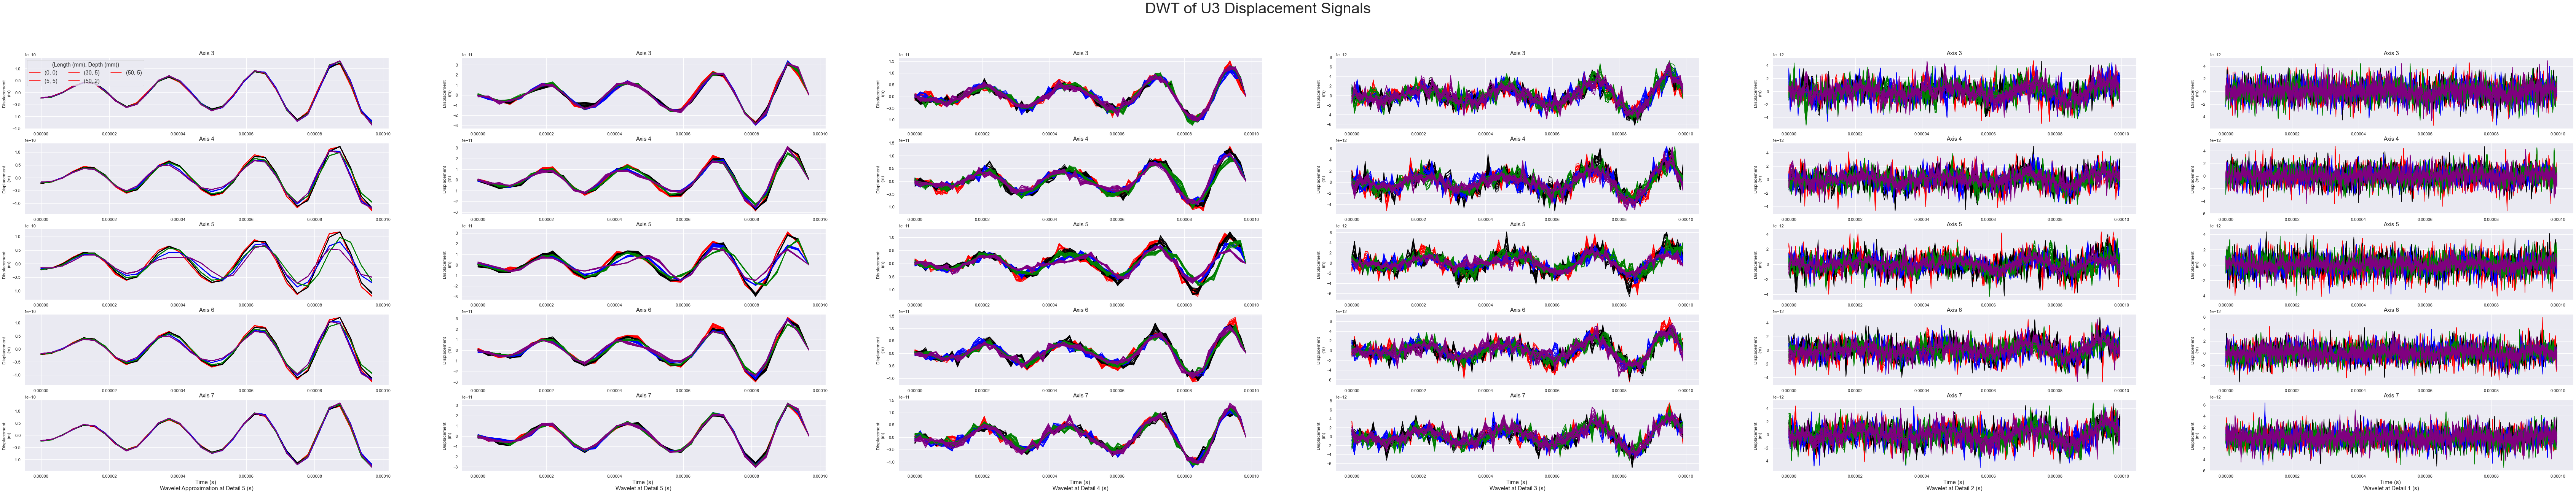

In [360]:
fig, ax = plt.subplots(len(Axes), len(coeffs), figsize = (120,20))
i = 0

for axis in Axes:
    j = 0;
    subtitle = '';

    for state in states:

        is_state = (mode['Crack Properties',variables[0]] == state[0])&(mode['Crack Properties',variables[1]] == state[1]);
        is_axis  = mode['Transducer','Axis'] == axis;
        signal   = mode[is_state & is_axis];
        
        k = 0;
        for key in mode_dwts.keys():
            signal_dwt = signal[key];
            if np.nan in signal_time:
                continue

            max_value = signal_dwt.to_numpy().max()

            ax[i][k].plot(signal_dwt.columns,signal_dwt.transpose() ,color = colors[j], label = variables[0] + ' = ' + str(state[0]) + ', ' + variables[1] + ' = ' + str(state[1]));
            ax[i][k].set_ylabel('Displacement \n(m)', fontsize = 12)

            ax[i][k].set_title('Axis ' + str(axis), fontsize = 15)
            ax[-1][k].set_xlabel('Time (s) \n' + key, fontsize = 15)

            k = k + 1;

        j = j + 1;

    i = i + 1;


ax[0][0].legend(states, title = '(' + variables[0] + ', ' + variables[1] + ')', loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large', ncol = 3);

textyloc = max_value;

fig.suptitle('DWT of ' + StrainCoefficient + ' Displacement Signals',fontsize = 40)

fig.savefig('dwt',dpi = 250)

## CWT

The continuous wavelet transform (CWT) is a more powerful version of the DWT. For each signal, it provides a contour plot on a 2D axis: horizontal axis = time and vertical axis = frequency. The quantity at each cell is a complex value, and the magnitude corresponds to the color on the contour plot. 

Currently, there is no reliable CWT function in Python. Thus, we'll be running the algorithm in Matlab and exporting the results into Python.

## STFT

## Principal Component Analysis

Objective: Classify the noisy damage data via the amplitudes in the frequency domains. 

Begin by isolating only the frequencies which best describe teh signal. For our purposes, this will be the frequencies between 7,000 Hz and 13,000 Hz.

In [367]:
imp_freqs = []
for freq in list(mode['Frequency Domain (Hz)'].columns):
    if (freq <= 200000):
        imp_freqs.append(freq)

# imp_freqs = mode['Frequency Domain (Hz)'].columns

In [373]:
colors_index = [0] * 10 
colors_index[0:len(states)] = states
colors_dict = {}
i = 0

for color in colors:
    colors_dict[states[i]] = color
    i = i + 1

colors_dict

{(0, 0): 'red',
 (5, 5): 'black',
 (30, 5): 'blue',
 (50, 2): 'green',
 (50, 5): 'purple'}

Plot all frequency domains on one graph per transducer array. Color-code them by damaged state. We're examining Axis 2, the axis with the crack.

Run a preliminary PCA analysis on the frequency domains to transform the data to a 2-PC space. Obtain the amount of variance from the original dataset explained by the principal components.

Finally, plot the transducer frequency response on the transformed plane. Because the variance is explained concisely with just two principal components, it should be much easier to cluster the damaged states on the transformed plane. 

### Plot the Damaged States as Functions of Frequency Bins

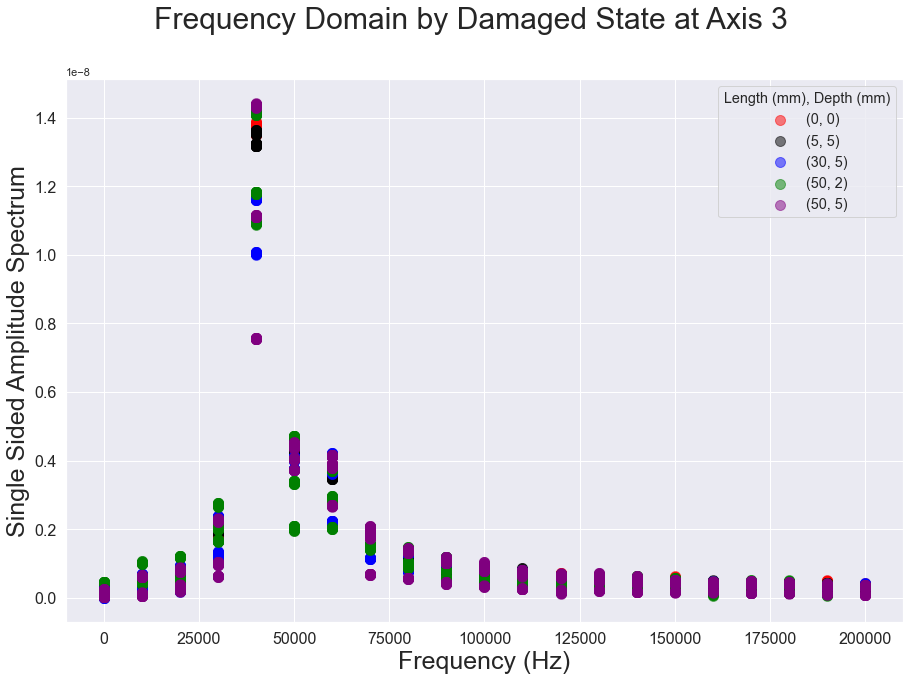

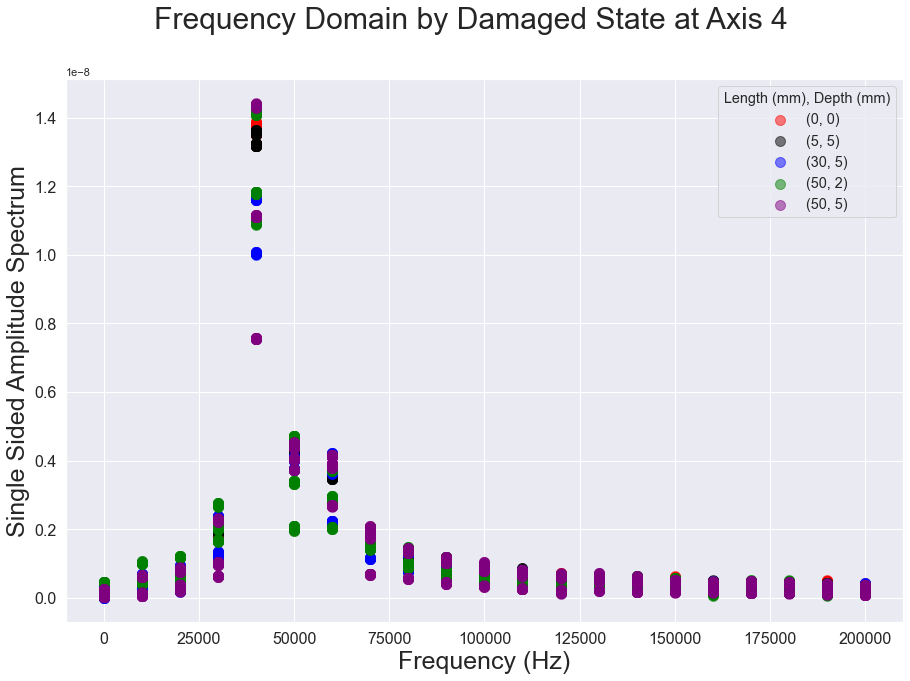

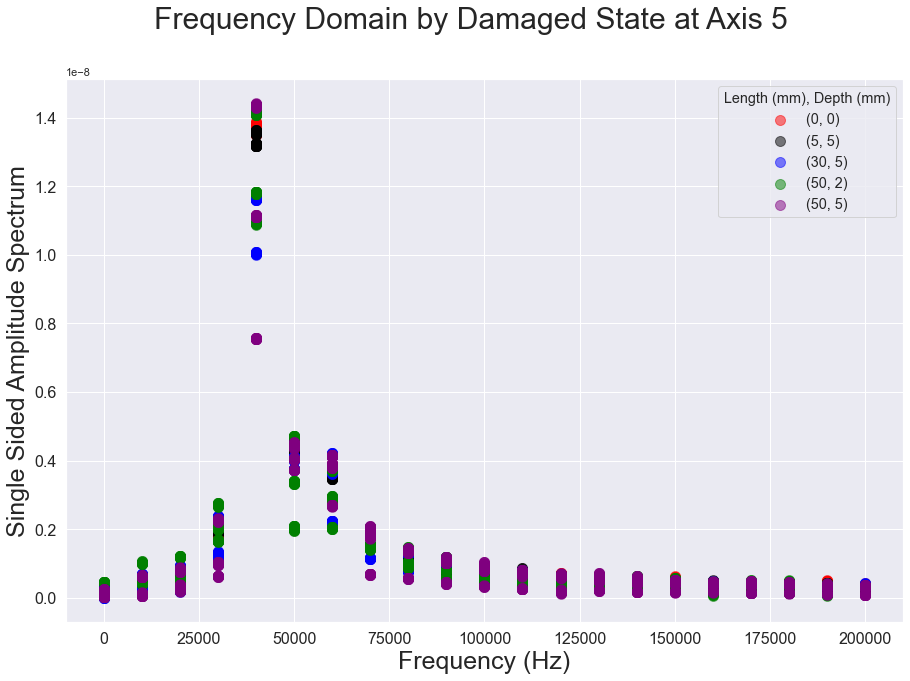

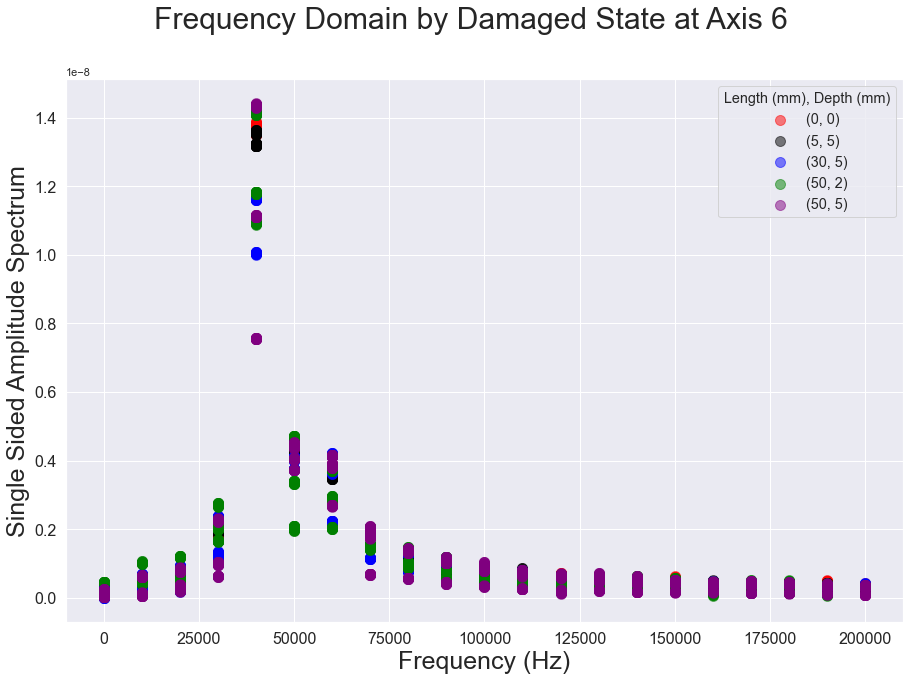

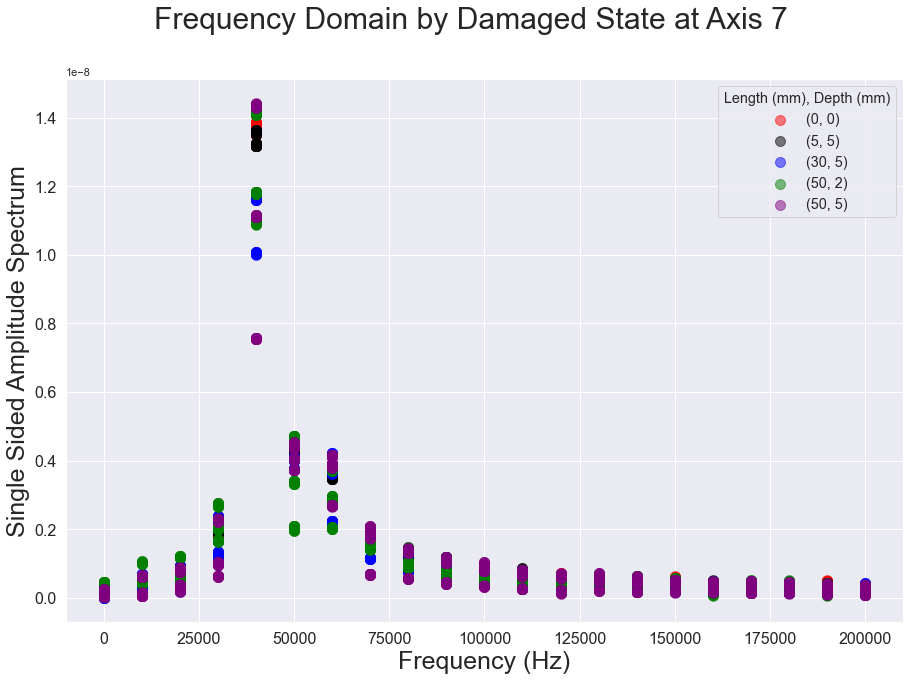

In [393]:
all_pcs = {}
pc_data = {}
interest_frequencies = {}

for axis in Axes:
    is_axis = mode['Transducer','Axis'] == axis
    interest_freqs = mode['Frequency Domain (Hz)'][imp_freqs]
    
    for variable in variables:
        interest_freqs[variable] = mode['Crack Properties', variable]
        
    interest_frequencies[axis] = interest_freqs
    fig, ax = plt.subplots(figsize = (15, 10))
    max_value = max(max_signals['Frequency Domain (Hz)'].max())
    
    for freq in imp_freqs:
        for state in states:
            c = colors_dict[state]
            x1 = np.ones(len(interest_freqs[(interest_freqs[variables[0]] == state[0])&(interest_freqs[variables[1]] == state[1])][freq].index));
            x1 = x1*freq
            plt.scatter(x = x1, y = interest_freqs[(interest_freqs[variables[0]] == state[0])&(interest_freqs[variables[1]] == state[1])][freq], alpha = 0.5, color = c, s = 100)
            
    plt.legend(states, title = (variables[0] + ', ' + variables[1]), loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('Single Sided Amplitude Spectrum', fontsize = 25)
    plt.xlabel('Frequency (Hz)', fontsize = 25)    
    fig.suptitle('Frequency Domain by Damaged State at Axis ' + str(axis), fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()

### Plot the Preliminary Results and Cumulative Explained Variance vs Number of PCs

In [397]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import pickle
from PIL import Image
from scipy.fft import fft, ifft
from scipy import signal
import pywt
# install lvm-read

In [398]:
def prePCA (freq_data):
    pca = RandomizedPCA(n_components=2)
    pca.fit(freq_data)
    freq_data_pca = pca.transform(freq_data)
    print("original shape:   ", freq_data.shape)
    print("transformed shape:", freq_data_pca.shape)
    label = "Variance explained by each principal component \nPC1: " + str(pca.explained_variance_ratio_[0]) + ' \nPC2: '+ str(pca.explained_variance_ratio_[1])
    print(label)
    
    fig, ax = plt.subplots(2,figsize=(10,10))
    
    comps = pca.components_
    ax[0].scatter(freq_data_pca[:,0],freq_data_pca[:,1])
    ax[0].set_xlabel('Component 1')
    ax[0].set_ylabel('Component 2');
    
    pca = RandomizedPCA().fit(freq_data)
    ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
    ax[1].set_xlabel('Number of components')
    ax[1].set_ylabel('Cumulative explained variance');
    
    ax[1].text(0, 1, label)
    
    return pca, comps, freq_data_pca

original shape:    (525, 21)
transformed shape: (525, 2)
Variance explained by each principal component 
PC1: 0.8301513282204699 
PC2: 0.13015346941822376


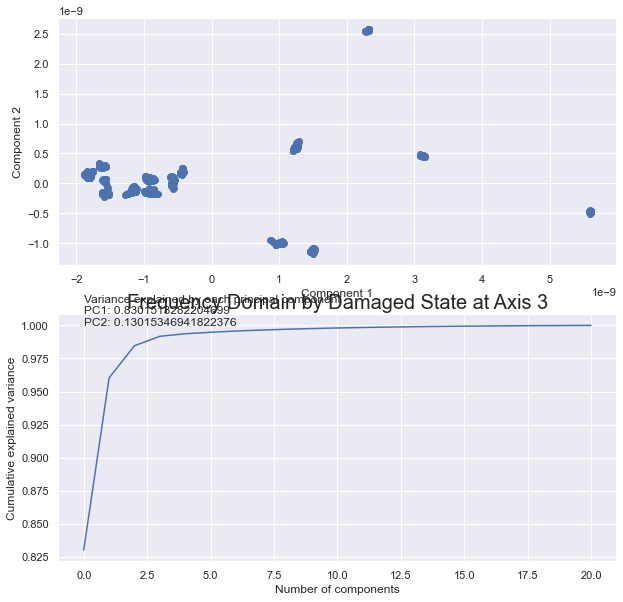

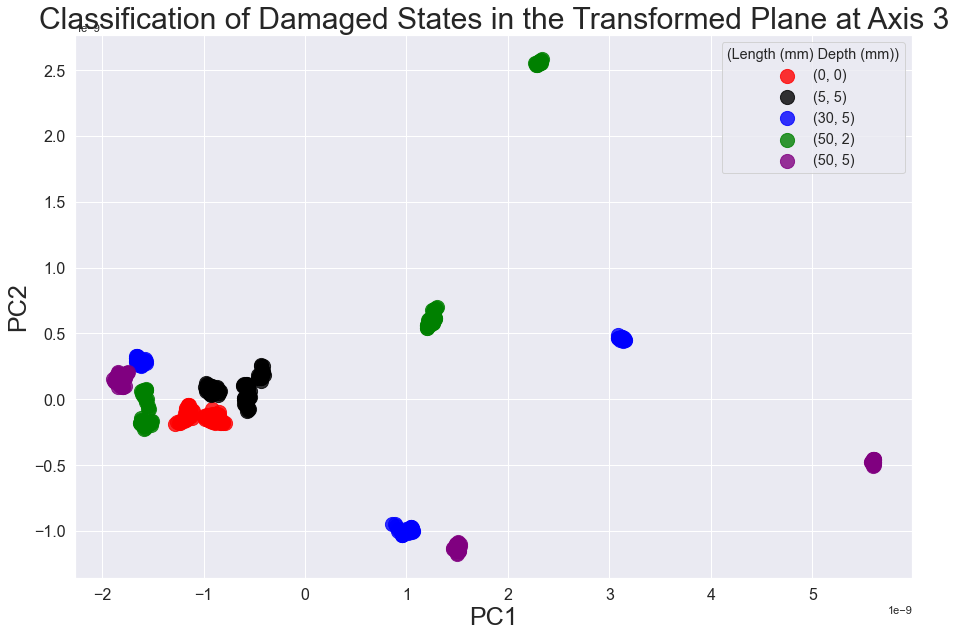

original shape:    (525, 21)
transformed shape: (525, 2)
Variance explained by each principal component 
PC1: 0.8301513282204693 
PC2: 0.13015346941822403


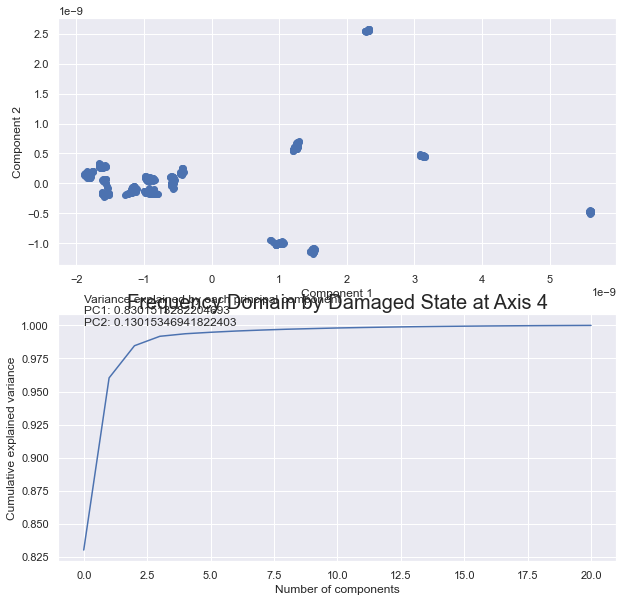

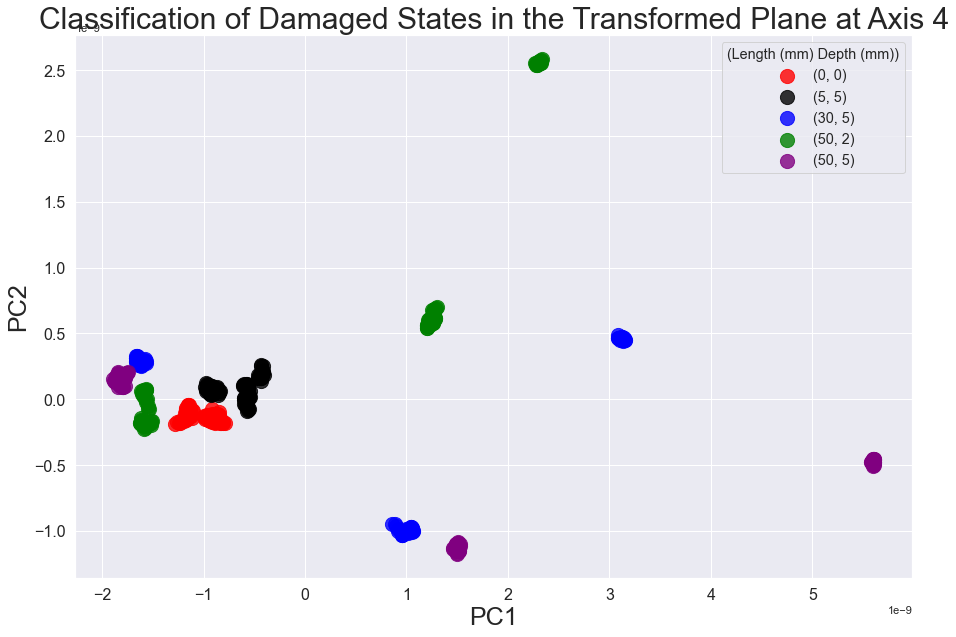

original shape:    (525, 21)
transformed shape: (525, 2)
Variance explained by each principal component 
PC1: 0.8301513282204691 
PC2: 0.13015346941822398


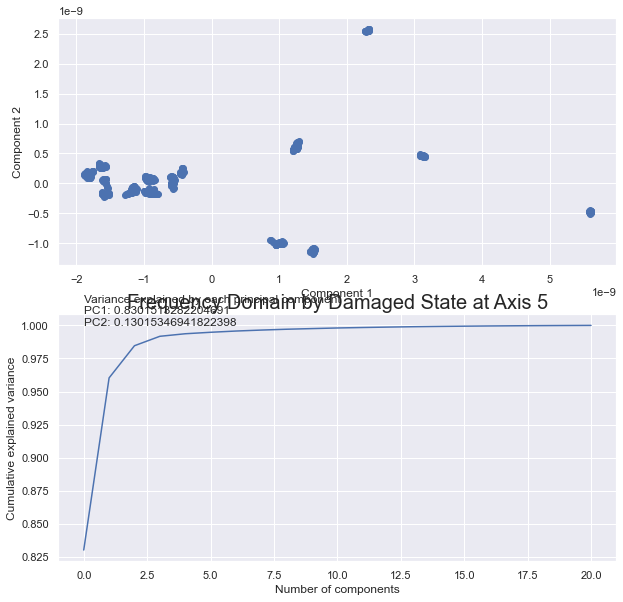

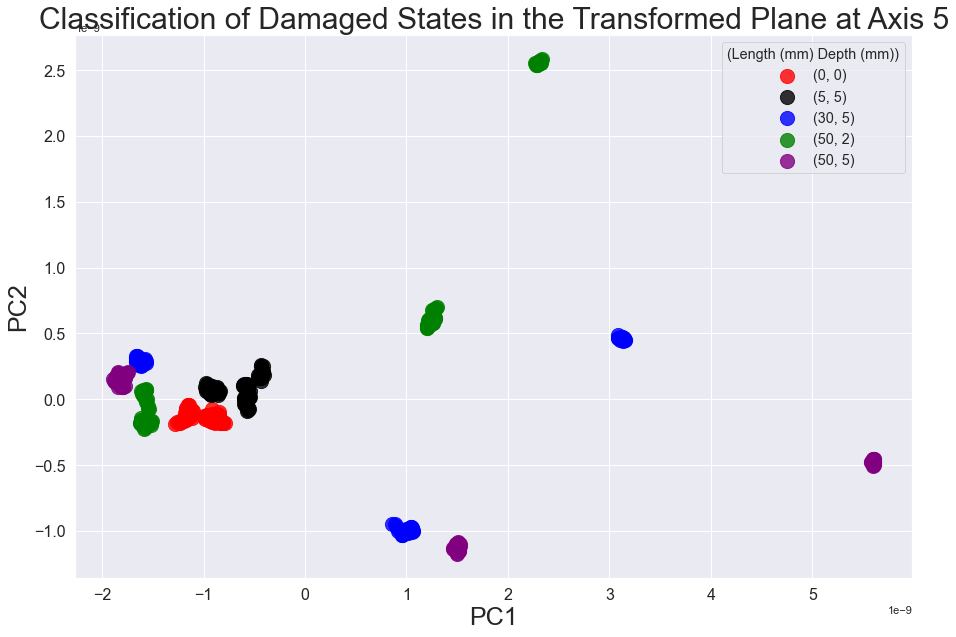

original shape:    (525, 21)
transformed shape: (525, 2)
Variance explained by each principal component 
PC1: 0.8301513282204697 
PC2: 0.13015346941822392


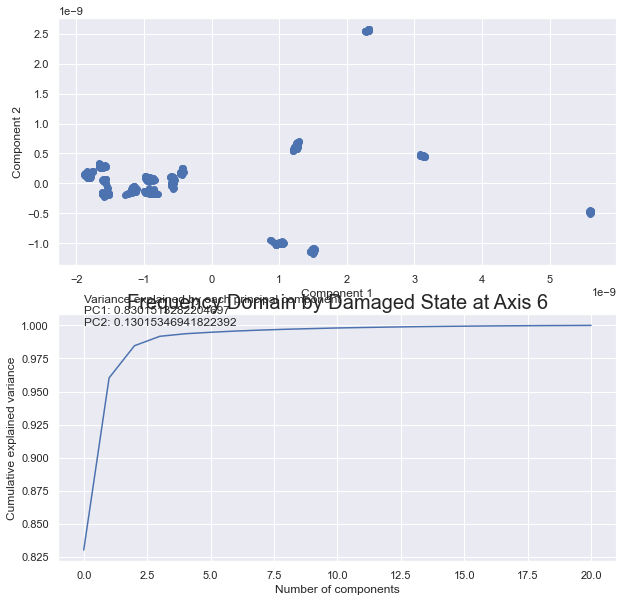

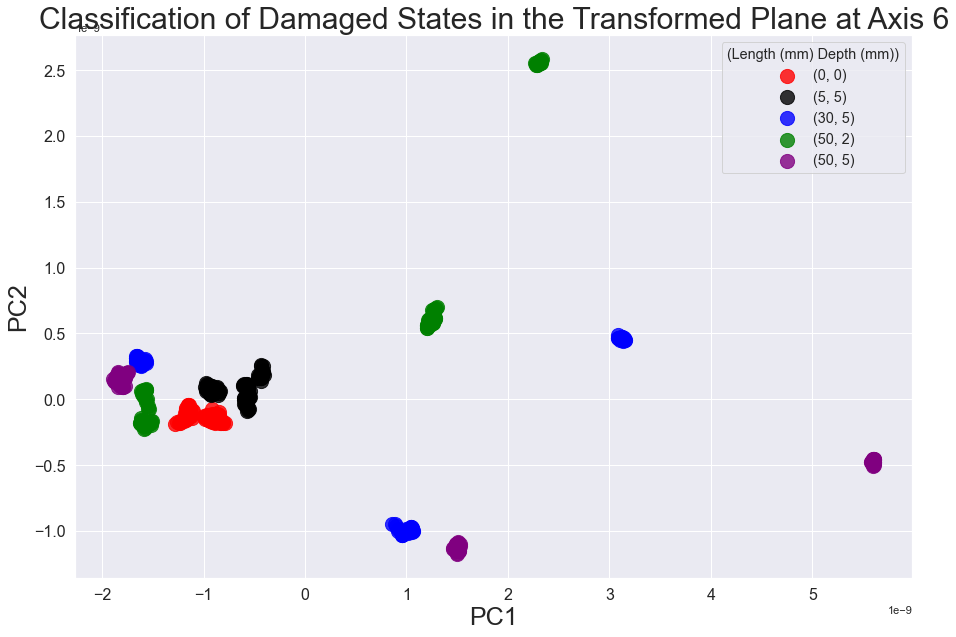

original shape:    (525, 21)
transformed shape: (525, 2)
Variance explained by each principal component 
PC1: 0.8301513282204693 
PC2: 0.13015346941822403


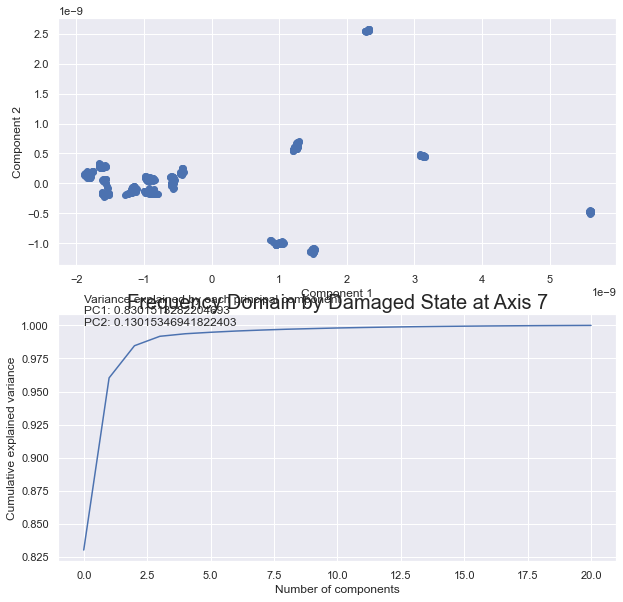

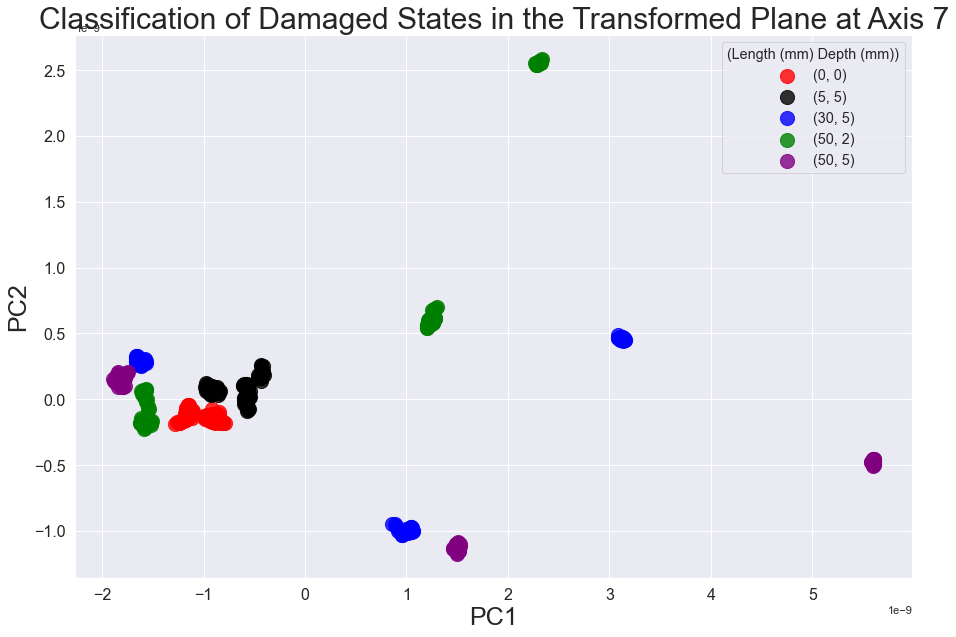

In [403]:
for axis in Axes:
    interest_freqs = interest_frequencies[axis]
    freq_pca, comps, transformed_freq = prePCA(interest_freqs.drop(variables, axis = 1))
    plt.title('Frequency Domain by Damaged State at Axis ' + str(axis), fontsize = 20)
    plt.grid(which='major', linestyle='-')    
    plt.show()
    
    reduced_dataset = pd.DataFrame(transformed_freq)
    reduced_dataset.columns = ['Principal Component 1', 'Principal Component 2']
    interest_freqs.reset_index(drop=True, inplace=True)
    reduced_dataset.reset_index(drop=True, inplace=True)
    reduced_dataset[variables] = interest_freqs[variables]
    reduced_dataset.set_index(variables)

    pc_data[axis] = reduced_dataset

    pcs         = pd.DataFrame(comps)
    pcs.columns = imp_freqs
    pcs.index   = ['PC1','PC2']
    pcs

    all_pcs[axis] = pcs
    
    # Plot the damage data on the transformed plane and color code them by damaged state
    fig, ax = plt.subplots(figsize = (15,10))

    for state in states:
        x = reduced_dataset[(reduced_dataset[variables[0]] == state[0])&(reduced_dataset[variables[1]] == state[1])]['Principal Component 1'];
        y = reduced_dataset[(reduced_dataset[variables[0]] == state[0])&(reduced_dataset[variables[1]] == state[1])]['Principal Component 2'];
        c = colors_dict[state];
        plt.scatter(x = x, y = y, alpha = 0.8, color = c, s= 200); 

    plt.legend(colors_dict.keys(), title = '(' + variables[0] + ' ' + variables[1] +')', loc = 'best', fancybox = True, fontsize = 'large', title_fontsize = 'large');
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)    
    plt.ylabel('PC2', fontsize = 25)
    plt.xlabel('PC1', fontsize = 25)    
    plt.title('Classification of Damaged States in the Transformed Plane at Axis ' + str(axis) , fontsize = 30)
    plt.grid(which='major', linestyle='-')    
    plt.show()

In [ ]:
reduced_dataset = pd.DataFrame(transformed_freq)
reduced_dataset.columns = ['Principal Component 1', 'Principal Component 2']
interest_freqs.reset_index(drop=True, inplace=True)
reduced_dataset.reset_index(drop=True, inplace=True)
reduced_dataset[variables] = interest_freqs[variables]
reduced_dataset.set_index(variables)

pc_data[Array] = reduced_dataset

pcs         = pd.DataFrame(comps)
pcs.columns = imp_freqs
pcs.index   = ['PC1','PC2']
pcs

all_pcs[Array] = pcs

## Machine Learning

We will be applying the support vector machine (SVM) method to increase the dimensionality of the PCA results, mathematically group all the datapoints between characteristic hyperplanes, verify the accuracy of the results, and save a model for later validation and use.

In [191]:
import sklearn.svm as svm

Begin by extracting samples from the generated dictionaries to form data arrays and target vectors.

Standardize the data and transform it to a dataset of z-scores

The support vector classifier (SVC) is the border between any two classes in the native dimension of the dataset. In the higher dimension, it is known as the hyperplane. 
A decision function shape of ovo means that the SVC selection method is one-vs-one. This means that one SVC exists between any pair of classes. The total number of SVCs in this case is n*(n-1)/2, where is is the number of classes.
Alternatively, there is a selection method known as ovr (one-vs-rest). This means that one SVC exist between any one class and all other classes. The total number of SVCs in this case is n.

In [449]:
interest_freqs = interest_frequencies[5]
interest_freqs['Damage'] = '(' + interest_freqs[variables[0]].astype(str) +","+ interest_freqs[variables[1]].astype(str) + ')'
interest_freqs

0  9999.899900901893  19999.799801803787  29999.699702705682  \
0    1.286060e-10       4.009064e-10        4.871349e-10        1.814725e-09   
1    1.533877e-10       4.564116e-10        5.538424e-10        1.962603e-09   
2    1.138378e-10       3.751073e-10        4.603188e-10        1.791542e-09   
3    1.533911e-10       4.564102e-10        5.538419e-10        1.962599e-09   
4    1.286106e-10       4.009102e-10        4.871401e-10        1.814728e-09   
..            ...                ...                 ...                 ...   
520  2.752992e-11       1.181190e-10        2.960240e-10        1.113167e-09   
521  2.353292e-11       9.123024e-11        2.916725e-10        1.102938e-09   
522  2.195957e-11       1.120965e-10        2.828964e-10        1.098609e-09   
523  2.272079e-11       1.419584e-10        2.944409e-10        1.111779e-09   
524  2.343780e-11       1.454684e-10        2.757332e-10        1.107045e-09   

     39999.599603607574  49999.49950450946  59999.399405411365  \
0          1.355321e-08       4.440695e-09        3.608443e-09   
1          1.380080e-08       4.460346e-09        3.715298e-09   
2          1.348470e-08       4.317187e-09        3.793866e-09   
3          1.380079e-08       4.460346e-09        3.715296e-09   
4          1.355321e-08       4.440695e-09        3.608443e-09   
..                  ...                ...                 ...   
520        1.160872e-08       4.024933e-09        4.141009e-09   
521        1.160120e-08       4.021921e-09        4.148330e-09   
522        1.159660e-08       4.056443e-09        4.133061e-09   
523        1.160379e-08       4.069989e-09        4.137800e-09   
524        1.159900e-08       4.062232e-09        4.144675e-09   

     69999.29930631325  79999.19920721515  89999.09910811705  ...  \
0         1.912659e-09       1.308571e-09       1.040546e-09  ...   
1         1.901238e-09       1.309177e-09       1.018684e-09  ...   
2         1.870829e-09       1.282623e-09       9.852066e-10  ...   
3         1.901236e-09       1.309177e-09       1.018684e-09  ...   
4         1.912657e-09       1.308570e-09       1.040546e-09  ...   
..                 ...                ...                ...  ...   
520       1.861646e-09       1.260335e-09       1.038689e-09  ...   
521       1.868717e-09       1.251064e-09       1.024770e-09  ...   
522       1.867206e-09       1.245089e-09       1.017647e-09  ...   
523       1.888749e-09       1.281265e-09       1.010604e-09  ...   
524       1.886238e-09       1.290619e-09       1.021033e-09  ...   

     149998.4985135284  159998.3984144303  169998.29831533218  \
0         4.426296e-10       4.076112e-10        3.777531e-10   
1         4.408244e-10       4.049502e-10        3.755317e-10   
2         4.255555e-10       3.910865e-10        3.625786e-10   
3         4.408245e-10       4.049491e-10        3.755306e-10   
4         4.426296e-10       4.076104e-10        3.777532e-10   
..                 ...                ...                 ...   
520       4.016974e-10       4.819388e-10        2.948554e-10   
521       4.105160e-10       4.813958e-10        3.205084e-10   
522       4.188509e-10       4.589886e-10        3.149530e-10   
523       4.132641e-10       4.674202e-10        2.928396e-10   
524       4.174669e-10       4.746425e-10        3.079229e-10   

     179998.1982162341  189998.09811713596  199997.99801803785  Length (mm)  \
0         3.526757e-10        3.305694e-10        3.112417e-10            0   
1         3.506893e-10        3.288588e-10        3.096331e-10            0   
2         3.387500e-10        3.175736e-10        2.990018e-10            0   
3         3.506892e-10        3.288583e-10        3.096329e-10            0   
4         3.526751e-10        3.305692e-10        3.112403e-10            0   
..                 ...                 ...                 ...          ...   
520       2.651783e-10        3.670967e-10        2.781549e-10           30   
521       2.662581e-

In [451]:
pc_data[5].index = interest_freqs['Damage']
pc_data[5]

Principal Component 1  Principal Component 2  Length (mm)  Depth (mm)  \
Damage                                                                          
(0,0)           -8.764979e-10          -1.194559e-10            0           0   
(0,0)           -1.153077e-09          -4.467751e-11            0           0   
(0,0)           -7.899900e-10          -1.828954e-10            0           0   
(0,0)           -1.153068e-09          -4.467847e-11            0           0   
(0,0)           -8.765012e-10          -1.194511e-10            0           0   
...                       ...                    ...          ...         ...   
(30,5)           1.055093e-09          -9.795808e-10           30           5   
(30,5)           1.064008e-09          -9.972655e-10           30           5   
(30,5)           1.067051e-09          -1.001610e-09           30           5   
(30,5)           1.049187e-09          -9.948318e-10           30           5   
(30,5)           1.053055e-09          -1.005229e-09           30           5   

       Circumference  
Damage                
(0,0)             -1  
(0,0)             -1  
(0,0)             -1  
(0,0)             -1  
(0,0)             -1  
...              ...  
(30,5)       Outside  
(30,5)       Outside  
(30,5)       Outside  
(30,5)       Outside  
(30,5)       Outside  

[525 rows x 5 columns]

In [454]:
import sklearn.svm as svm

In [455]:
x = pc_data[5][pc_data[5].columns].values[:,[0,1]]
y = pc_data[5].index
scaler = StandardScaler()
X = scaler.fit_transform(x)

clf = svm.SVC(decision_function_shape = 'ovo')
clf.fit(X,y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 42)

In [457]:
ytest

Index(['(50,5)', '(50,5)', '(5,5)', '(5,5)', '(0,0)', '(50,2)', '(30,5)',
       '(30,5)', '(0,0)', '(50,2)',
       ...
       '(5,5)', '(50,5)', '(30,5)', '(50,2)', '(50,5)', '(0,0)', '(30,5)',
       '(5,5)', '(50,2)', '(50,2)'],
      dtype='object', name='Damage', length=132)

In [458]:
param_grid = {'C': np.logspace(np.log10(0.001), np.log10(20), num=200),
              'gamma': ['auto'],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, cv = 5, verbose = 0)
grid

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 1.05102541e-03, 1.10465441e-03, 1.16101986e-03,
       1.22026137e-03, 1.28252571e-03, 1.34796711e-03, 1.41674769e-03,
       1.48903782e-03, 1.56501659e-03, 1.64487220e-03, 1.72880248e-03,
       1.81701534e-03, 1.90972929e-03, 2.00717401e-03, 2.10959089e-03,
       2.21723363e-03, 2.33036889e-03, 2.44927691e-03, 2.574252...
       6.36687064e+00, 6.69174283e+00, 7.03319176e+00, 7.39206325e+00,
       7.76924632e+00, 8.16567530e+00, 8.58233223e+00, 9.02024926e+00,
       9.48051118e+00, 9.96425816e+00, 1.04726885e+01, 1.10070618e+01,
       1.15687016e+01, 1.21589993e+01, 1.27794173e+01, 1.34314923e+01,
       1.41168397e+01, 1.48371572e+01, 1.55942293e+01, 1.63899312e+01,
       1.72262342e+01, 1.81052099e+01, 1.90290356e+01, 2.00000000e+01]),
                         'gamma': ['auto'], 'kernel': ['rbf']})

In [459]:
grid.fit(Xtrain, ytrain)
clf_svm = SVC(C = grid.best_params_['C'], gamma = grid.best_params_['gamma'], random_state = 42)
clf_svm.fit(Xtrain, ytrain)

ypred = clf_svm.predict(Xtest)

In [234]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Text(0.5, 1.0, 'Testing Confusion Matrix at Axis 5')

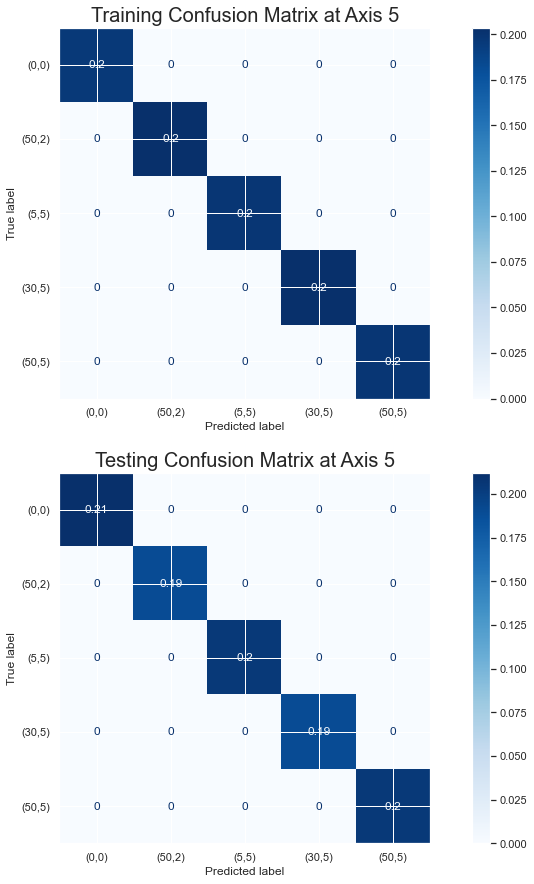

In [462]:
fig, ax = plt.subplots(2,1,figsize = (15,15))
# plt.colorbar()

cm_train = plot_confusion_matrix(clf_svm, Xtrain, ytrain, normalize = 'all', display_labels = y.unique(), cmap = "Blues", ax = ax[0])
cm_test  = plot_confusion_matrix(clf_svm, Xtest,  ytest,  normalize = 'all', display_labels = y.unique(), cmap = 'Blues', ax = ax[1])

# ax[0].plot(cm_train)
# ax[1].plot(cm_test)

ax[0].set_title('Training Confusion Matrix at Axis 5' , fontsize = 20)
# ax[0].plot('cm_train')
# ax[0].set_xlabel('Predicted Label')
# ax[0].set_ylabel('True Label')

ax[1].set_title('Testing Confusion Matrix at Axis 5' , fontsize = 20)
# ax[1].plot('cm_test')
# ax[1].set_xlabel('Predicted Label')
# ax[1].set_ylabel('True Label')

# fig.savefig(array + '.png', dpi = 250)

In [467]:
clf_svm.predict(np.array([X1.ravel(), X2.ravel()]).T)

array(['(50,5)', '(50,5)', '(50,5)', ..., '(50,5)', '(50,5)', '(50,5)'],
      dtype=object)

ValueError: could not convert string to float: '(50,5)'

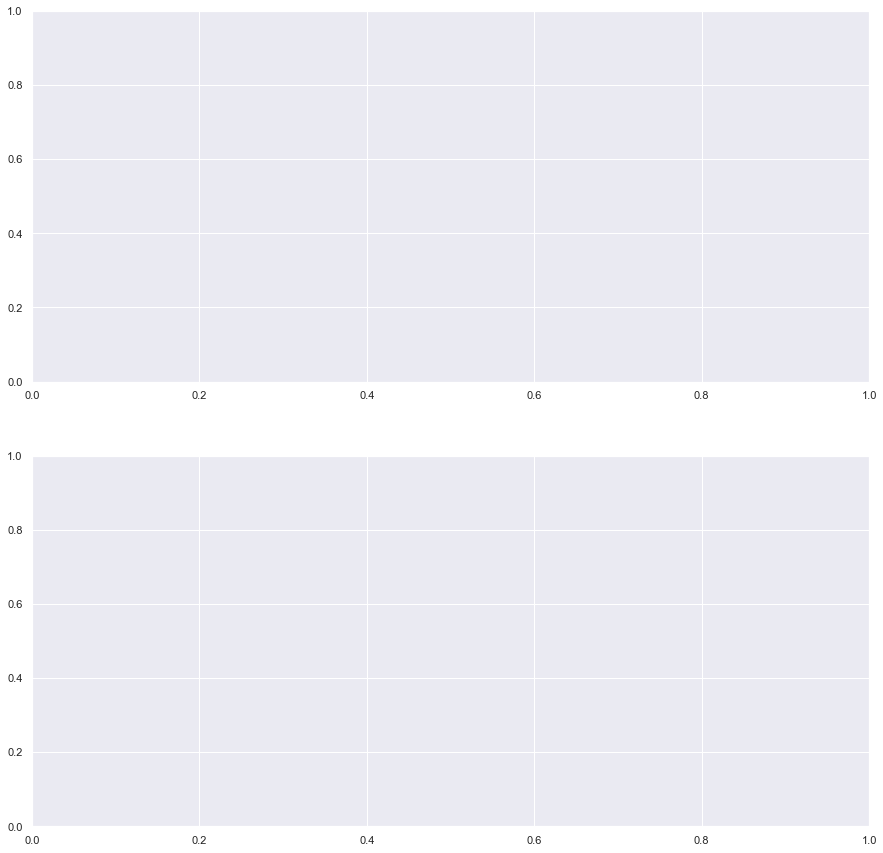

In [463]:
from matplotlib.colors import ListedColormap


fig, ax   = plt.subplots(2,1,figsize = (15,15))

# Visualising the Training set results

X_Set, Y_Set = Xtrain, ytrain

# fill the regions computed by SVM, color-code them in the plot by damaged state 
X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
ax[0].contourf(X1, X2, clf_svm.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
ax[0].set_xlim(X1.min(), X1.max())
ax[0].set_ylim(X2.min(), X2.max())

ax[0].set_title('Support Vector Machine (Training set)')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('Support Vector Machine Training Set at Axis 5', fontsize = 20)

# plot the datapoints, also color coded by damaged state
for i, j in enumerate(np.unique(Y_Set)):
    ax[0].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], color = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
ax[0].legend()
# plt.show()

# Visualising the Test set results

X_Set, Y_Set = Xtest, ytest

# fill the regions computed by SVM, color-code them in the plot by damaged state 
X1, X2 = np.meshgrid(np.arange(start = X_Set[:, 0].min() - 1, stop = X_Set[:, 0].max() + 1, step = 0.01),np.arange(start = X_Set[:, 1].min() - 1, stop = X_Set[:, 1].max() + 1, step = 0.01))
ax[1].contourf(X1, X2, clf_svm.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha = 0.5, cmap = 'hsv')
ax[1].set_xlim(X1.min(), X1.max())
ax[1].set_ylim(X2.min(), X2.max())

# plot the datapoints, also color coded by damaged state
for i, j in enumerate(np.unique(Y_Set)):
    ax[1].scatter(X_Set[Y_Set == j, 0], X_Set[Y_Set == j, 1], color = ListedColormap(('orange','yellow','green','blue','red'))(i), label = j)
ax[1].set_title('Support Vector Machine (Testing set)')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].legend()
# plt.show()

ax[1].set_title('Support Vector Machine Testing Set at Axis 5', fontsize = 20)

# hyperplanes_visual[array] = ax

# fig.savefig('Machine Learning Visual at ' + array + '.png', dpi = 250)

## Save all Data

The most meaningful additions to the data, analysis, and resutls are the transformed domains, which are all stored in the same mode dataframe. Thus, we're definitely saving it.

In [361]:
pickle.dump(mode, open('Mode 1, ' + StrainCoefficient + ' Signal Response','ab'))